# Evaluate random "monkey" model for matchmaking
Given our relevant cancer cell lines and labels of shared therapeutic sensitivity, we assign a random distance to all cell lines across many iterations to understand what our performance is if a monkey were to assign distances between cell lines.

## Set up dataframe with labels

In [1]:
import numpy as np
import pandas as pd
import pickle
import scipy

from metrics import Random
from plots import AveragePrecision, AveragePrecisionK
%load_ext autoreload
%autoreload 2

def format_gdsc_pairs(dataframe):
    return (dataframe
                .sort_values([case, comparison], ascending=[True, False])
                .set_index([case, comparison])
                .rename(columns={n_sensitive_union: n_shared})
                .loc[:, n_shared])

N = 100000

case = 'case'
comparison = 'comparison'
n_sensitive_union = 'n_sensitive_union'
n_shared = 'n_shared'

summary = pd.read_csv('formatted/cell-lines.summary.txt', sep='\t')
pairwise = pd.read_csv('formatted/sanger.gdsc.pairwise-sensitive.txt', sep='\t')
samples = summary[summary['use_evaluate'].eq(1)]['sanger'].tolist()
pairwise = pairwise[pairwise['case'].isin(samples) & pairwise['comparison'].isin(samples)]
pairwise = format_gdsc_pairs(pairwise)
pairwise = pairwise.reset_index()

df = pairwise.copy(deep=True)

## Assign random distance and evaluate these generated models

In [13]:
import time 
start_time = time.time()

mAP_results = Random.evaluate_random_model(samples, df, N)
    
end_time = time.time()
time_statement = f"{round((end_time - start_time), 4)}"
print(time_statement)

64063.4956


In [ ]:
(pd.Series(mAP_results)
 .to_frame()
 .reset_index()
 .rename(columns={'index': 'seed', 0: 'mAP'})
 .to_csv('tables/random.mAP-by-seed.txt', sep='\t', index=False)
)

## Characterize
We look at the mean mAP as well as variance and standard deviation. We then pick a seed that represents the mean mAP and +/- one standard deviation. We also plot the distribution of mAP values.

In [1]:
import pandas as pd

In [2]:
#mAP_results = pd.read_csv('tables/random.mAP-by-seed.txt', sep='\t', index_col='seed')
#map_series = mAP_results.loc[:,'mAP']
map_series = pd.Series(mAP_results)
mean = map_series.mean()
std = map_series.std()
var = map_series.var()

def write_pickle(handle, output):
    file = open(handle, 'wb')
    pickle.dump(output, file)
    file.close()

def return_closest_seed(series, value):
    return series.subtract(value).abs().sort_values().index[0]

test_seeds = {
    'random_mean': return_closest_seed(map_series, mean), 
    'random_plus_one_std': return_closest_seed(map_series, mean + std),
    'random_minus_one_std': return_closest_seed(map_series, mean - std)
}

random_models = pairwise.copy(deep=True)
evaluated_random_models = Random.evaluate_random_models(samples, random_models, test_seeds)

description_random = 'Randomly shuffle cell lines against one another across 100,000 seeds. This uses the seed of the average mean average precision.'
description_random_plus = 'Randomly shuffle cell lines against one another across 100,000 seeds. This uses the seed of the average mean average precision plus one standard deviation.'
description_random_minus = 'Randomly shuffle cell lines against one another across 100,000 seeds. This uses the seed of the average mean average precision minus one standard deviation.'

evaluated_random_models['random_mean']['description'] = description_random
evaluated_random_models['random_plus_one_std']['description'] = description_random_plus
evaluated_random_models['random_minus_one_std']['description'] = description_random_minus

#write_pickle('tables/models.random.evaluated.pkl', evaluated_random_models)

random_mean 0.09549071618037135 0.09946949602122016 0.09460654288240494 0.1104324533000405
random_plus_one_std 0.10344827586206896 0.11140583554376658 0.10610079575596815 0.11344556192091224
random_minus_one_std 0.11936339522546419 0.1206896551724138 0.10875331564986737 0.11160823768893122


In [3]:
mAP_results

,mAP
seed,
0,0.113005
1,0.110596
2,0.111148
3,0.110349
4,0.112485
...,...
99995,0.109911
99996,0.112054
99997,0.113941


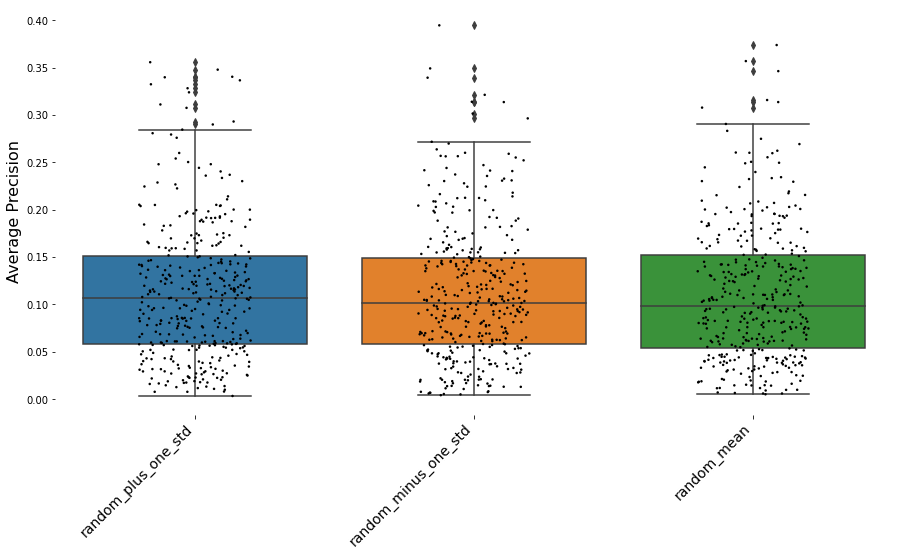

In [4]:
AveragePrecision.plot(evaluated_random_models, test_seeds.keys(), 'random_models')

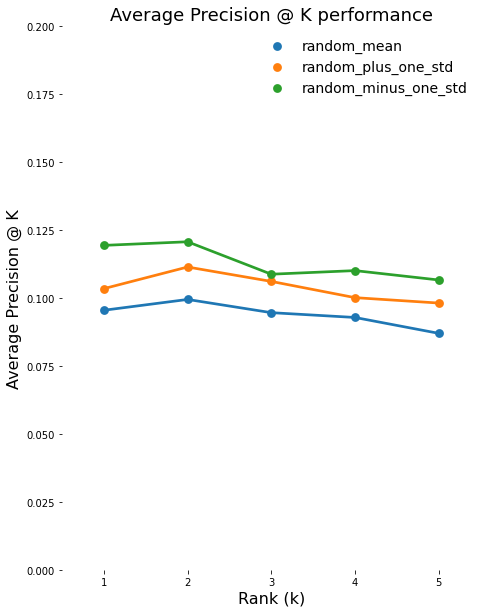

In [5]:
AveragePrecisionK.plot(evaluated_random_models, test_seeds.keys(), 'random_models')

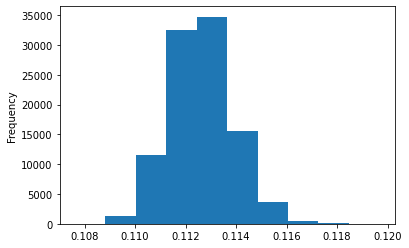

In [6]:
map_series.plot(kind='hist')

In [7]:
scipy.stats.normaltest(map_series)

NormaltestResult(statistic=1052.1066664442847, pvalue=3.450962140592161e-229)